In [18]:
import os
import cv2
import numpy as np
import glob
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


# Getting Familiar with Image Data

In [4]:
# Setting up the path to the files
path_images = '/Users/arasdirekoglu/Documents/Daten/rs19_val/uint8/rs19_val/'

Labels are: [ 1  5  7  8  9 10 12 15 17]
The image was the length of 1920
The image was the height of 1080


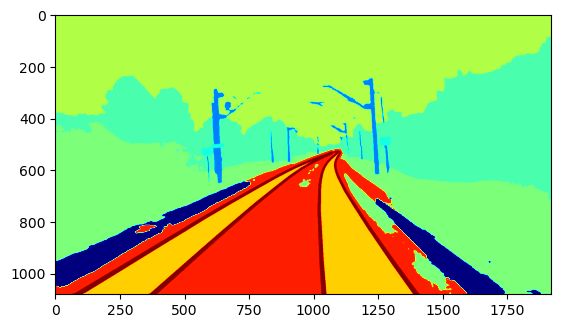

In [9]:
# Read a Random Image 
temp_mask = cv2.imread(path_images+'rs08171.png')

# Print out mask labels of this image
label = np.unique(temp_mask[:,:,0])
print("Labels are:", label)

# Size X - Length of image 
size_x = temp_mask.shape[1]
print("The image was the length of", size_x)

# Size Y - Height of Image 
size_y = temp_mask.shape[0]
print("The image was the height of", size_y)

# Show image 
plt.imshow(temp_mask[:,:,0], cmap='jet')

# Reading the Data

In [22]:
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Daten/rs19_val/uint8/rs19_val/'
path_images = '/Users/arasdirekoglu/Documents/Daten/rs19_val/jpgs/rs19_val/' 

# Setting up a breaker for test run 
breaker = 0

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop 
for filename in os.listdir(path_images):
    breaker += 1
    if filename.endswith('.jpg'):
        image = Image.open(path_images+filename)
        image = np.array(image.resize((256, 256),3))
        mask = Image.open(path_masks+filename[:7]+'.png')
        mask = np.array(mask.resize((256,256),3))
        mask = np.expand_dims(mask, axis=2)
        for layer in range(len(mask[0,0,:])):
            # mask[:int(size_y/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==500:
        break

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

image:  (500, 256, 256, 3)
mask:  (500, 256, 256)
image:  (500, 256, 256, 3)
mask:  (500, 256, 256, 1)
unique labels in mask [0 1]


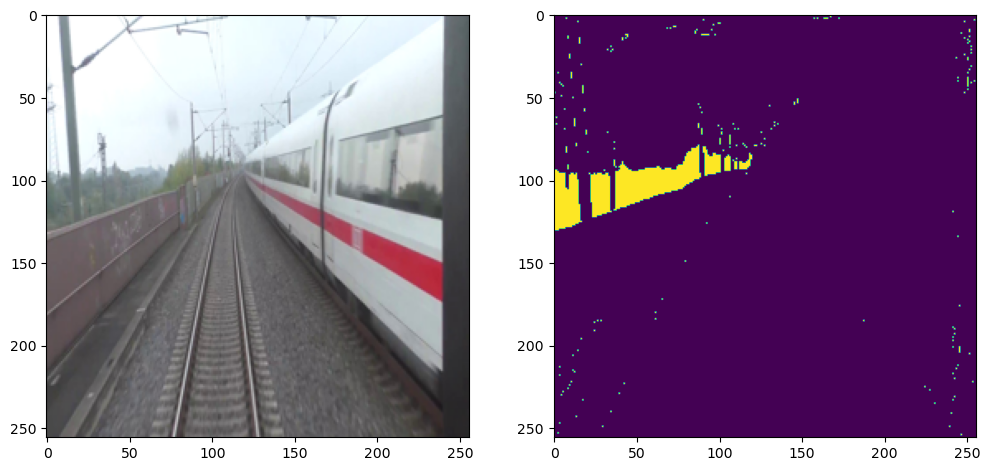

In [30]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()


# Split of Data

In [23]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [24]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [25]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [26]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=10,
                        epochs=2,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/2
40/40 [==============================] - 127s 3s/step - loss: 0.3297 - iou_score: 0.5479 - mse: 0.0996 - val_loss: 8.0378 - val_iou_score: 0.3402 - val_mse: 0.4636
Epoch 2/2
40/40 [==============================] - 124s 3s/step - loss: 0.2290 - iou_score: 0.6556 - mse: 0.0683 - val_loss: 0.5146 - val_iou_score: 0.6115 - val_mse: 0.1036


1/1 [==============================] - 0s 253ms/step


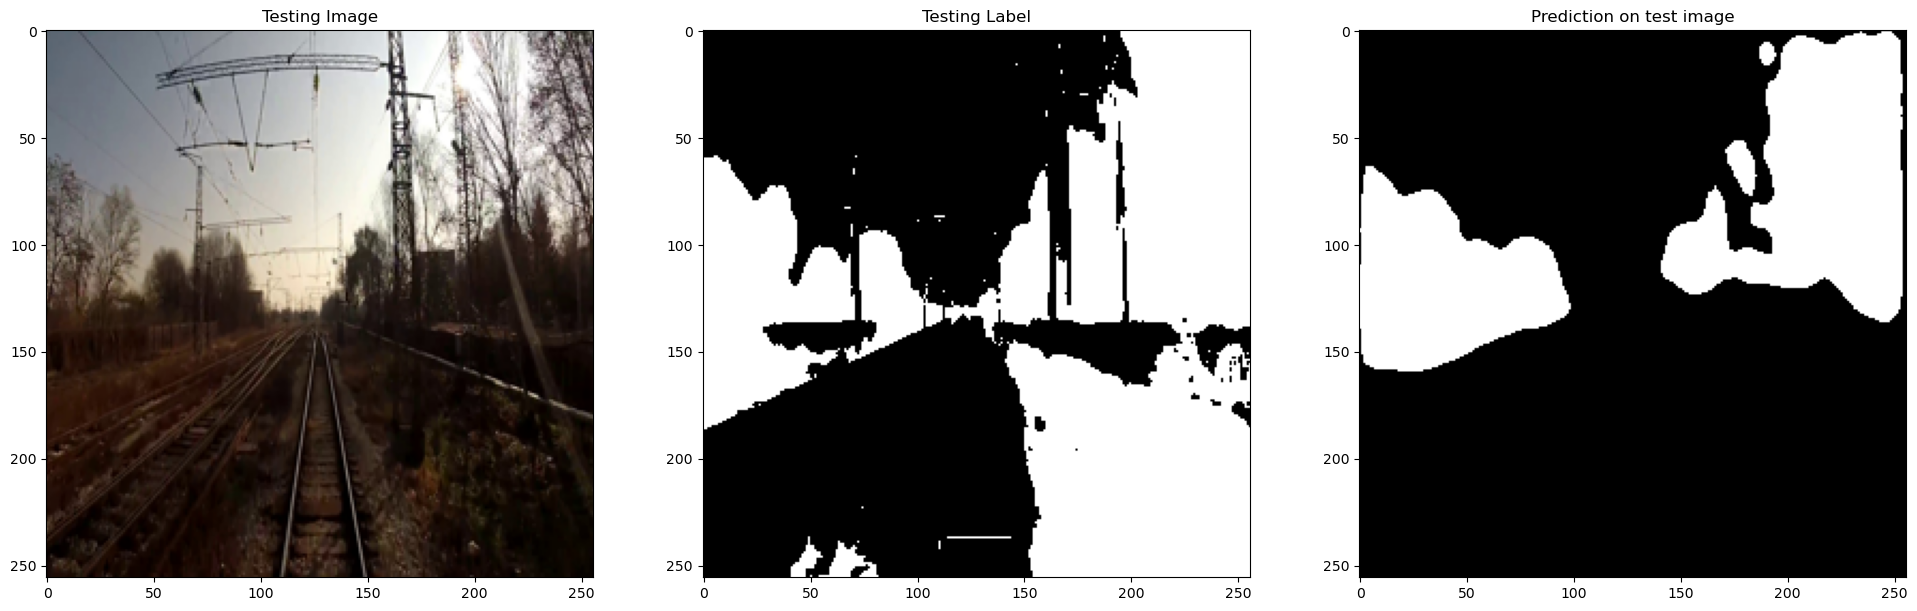

In [29]:
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.99
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()